In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Item Rando:
# 26 'randomizeable' items
# 100 'randomizeable' drop locations
# idea 1: location : item_id
# ~ 500 bits (locations * log(items))
# idea 2: item : location_id
# ~ 700 bits (locations * log(locations))
# idea 3: location : common_item_id
# major_item : location_id
# 300 bits + 126 bits

In [3]:
# Door Rando:
# ~550 doors
# idea 1: door: door_id
# 550 * log(550) = 5500 bits
# idea 2: left_door : right_door_id
# top_door : bottom_door_id
# 225 * log(225) = 2040
# idea 3:
# X, Y
# overworld is ~ 128 x 128
# 14 bits per room * 255 rooms = 3570

In [4]:
import sys
sys.path.append("../..")

In [5]:
from encoding.parse_rooms import parse_rooms, parse_exits, dictify_rooms

In [6]:
from functools import cache
from itertools import combinations

In [7]:
rooms = parse_rooms("../../encoding/dsl/rooms_for_alloy.txt")
exits = parse_exits("../../encoding/dsl/exits_for_alloy.txt")
design = dictify_rooms(rooms, exits)

In [8]:
from rom_tools.rom_manager import RomManager
from abstraction_validation.sm_paths import *

In [9]:
from bdds.bdd_core import *
from bdds.node_bdds import *

In [10]:
from functools import reduce

In [11]:
all_nodes = []
for r, room in rooms.items():
    for node in room.graph.name_node.keys():
        all_nodes.append(node)
node_ids = {n:i for i,n in enumerate(all_nodes)}

In [12]:
# Issue with design translation via chopping off the last _
node_ids["Spore_Spawn_Spawn"] = node_ids["Spore_Spawn_Spore_Spawn"]
node_ids["Golden_Torizo_Torizo"] = node_ids["Golden_Torizo_Golden_Torizo"]
node_ids["Mother_Brain_Brain"] = node_ids["Mother_Brain_Mother_Brain"]

In [13]:
major_items = ["MB", "B", "SPB", "G", "SA", "V", "GS", "SB", "HJ", "CB", "WB", "PLB", "Spazer", "XR", "IB", "SJ"]
minor_items = ["M", "S", "PB", "E", "RT"]
rando_items = ["B", "MB", "PB", "SPB", "S", "M", "G", "SA", "V", "GS", "SB", "HJ", "CB", "WB", "E", "PLB", "Spazer", "RT", "XR", "IB", "SJ"]
assert set(rando_items) == set(major_items) | set(minor_items)

In [14]:
context = mk_context_id(node_ids)

In [15]:
from functools import reduce

In [16]:
def reduce_and(clauses):
    return reduce(lambda x, y: x & y, clauses, context.true)

def reduce_or(clauses):
    return reduce(lambda x, y: x | y, clauses, context.false)

In [17]:
def loc_id(room_name, node_name, when="prev"):
    node_id = node_ids[f"{room_name}_{node_name}"]
    return context.add_expr(f"node_id_{when} = {node_id}")

@cache
def item_transitions(item_gained=None):
    if item_gained is None:
        return context.add_expr("(items_unchanged)", with_ops = True)
    clauses = []
    for i in design["Items"] | design["Bosses"]:
        if i == item_gained:
            clause = context.add_expr(f"{i}_prev < {i}_next")
        else:
            clause = context.add_expr(f"{i}_prev = {i}_next")
        clauses.append(clause)
    return reduce_and(clauses)

def itemset_to_bdd(itemset):
    if len(itemset) == 0:
        return context.true
    else:
        return reduce_and([context.add_expr(f"{item}_prev = 1") for item in itemset])

def required_itemsets(itemsets):
    return reduce_or([itemset_to_bdd(itemset) for itemset in itemsets])

def rando_transitions(room_name, node_name, family, possible_items):
    t = context.false
    node_name = room_name + "_" + node_name
    drop_name = f"{family}_drop_{node_name}"
    for i,item in enumerate(possible_items):
        t |= context.add_expr(f"{drop_name} = {i}") & item_transitions(item)
    return t

In [18]:
major_nodes = []
minor_nodes = []
other_drop_nodes = []
for room_name, room in design["Rooms"].items():
    for node_name, d in room["Drops"].items():
        node_str = room_name + "_" + node_name
        if d in major_items:
            major_nodes.append(node_str)
        elif d in minor_items:
            minor_nodes.append(node_str)
        else:
            other_drop_nodes.append(node_str)

In [19]:
assert len(major_nodes) == len(major_items)
assert len(minor_nodes) == 100 - len(major_nodes)

In [20]:
drop_nodes = []
for room_name, room in design["Rooms"].items():
    for node_name, d in room["Drops"].items():
        if d in rando_items:
            drop_nodes.append(room_name + "_" + node_name)

In [21]:
assert len(drop_nodes) == 100

In [22]:
major_item_nodes = []
for room_name, room in design["Rooms"].items():
    for node_name, d in room["Drops"].items():
        if d in rando_items:
            drop_nodes.append(room_name + "_" + node_name)

In [23]:
#limit design freedom by setting a limited number of locations
#drop_nodes = ["Bomb_Torizo_Bombs", "Big_Pink_M2"]
n_major_rando = 16
n_minor_rando = 0
major_drop_nodes = major_nodes[:n_major_rando]
minor_drop_nodes = minor_nodes[:n_minor_rando]
#drop_nodes = []

In [24]:
design_vars = {
    **{ f"major_drop_{node}": (0,len(major_items)-1) for node in major_drop_nodes },
    **{ f"minor_drop_{node}": (0,len(minor_items)-1) for node in minor_drop_nodes }
}

In [25]:
if len(design_vars) > 0:
    context.declare(**design_vars)

In [26]:
context.vars

{'node_id_prev': {'type': 'int',
  'signed': False,
  'width': 10,
  'dom': (0, 701),
  'bitnames': ['node_id_prev_0',
   'node_id_prev_1',
   'node_id_prev_2',
   'node_id_prev_3',
   'node_id_prev_4',
   'node_id_prev_5',
   'node_id_prev_6',
   'node_id_prev_7',
   'node_id_prev_8',
   'node_id_prev_9']},
 'node_id_next': {'type': 'int',
  'signed': False,
  'width': 10,
  'dom': (0, 701),
  'bitnames': ['node_id_next_0',
   'node_id_next_1',
   'node_id_next_2',
   'node_id_next_3',
   'node_id_next_4',
   'node_id_next_5',
   'node_id_next_6',
   'node_id_next_7',
   'node_id_next_8',
   'node_id_next_9']},
 'node_id_goal': {'type': 'int',
  'signed': False,
  'width': 10,
  'dom': (0, 701),
  'bitnames': ['node_id_goal_0',
   'node_id_goal_1',
   'node_id_goal_2',
   'node_id_goal_3',
   'node_id_goal_4',
   'node_id_goal_5',
   'node_id_goal_6',
   'node_id_goal_7',
   'node_id_goal_8',
   'node_id_goal_9']},
 'node_id_temp': {'type': 'int',
  'signed': False,
  'width': 10,
  '

In [27]:
# Design
# Item
# Location

# Mess with the order
def static_order_score(name):
    var,tense,bit = name.rsplit('_', 2)
    bit = int(bit)
    is_design = var.startswith("major") or var.startswith("minor")
    is_loc = var.startswith("node_id")
    return (is_design, not is_loc, var, -bit, tense)

context.bdd.configure(reordering=False)
order = {v:i for i,v in enumerate(sorted(context.bdd.vars, key=static_order_score))}
#context.bdd.reorder()

In [28]:
context.bdd.reorder(order)

In [29]:
def var_levels():
    return sorted(context.bdd.var_levels.items(), key=lambda x: x[1])

In [32]:
var_levels()

[('node_id_goal_9', 0),
 ('node_id_next_9', 1),
 ('node_id_prev_9', 2),
 ('node_id_temp_9', 3),
 ('node_id_goal_8', 4),
 ('node_id_next_8', 5),
 ('node_id_prev_8', 6),
 ('node_id_temp_8', 7),
 ('node_id_goal_7', 8),
 ('node_id_next_7', 9),
 ('node_id_prev_7', 10),
 ('node_id_temp_7', 11),
 ('node_id_goal_6', 12),
 ('node_id_next_6', 13),
 ('node_id_prev_6', 14),
 ('node_id_temp_6', 15),
 ('node_id_goal_5', 16),
 ('node_id_next_5', 17),
 ('node_id_prev_5', 18),
 ('node_id_temp_5', 19),
 ('node_id_goal_4', 20),
 ('node_id_next_4', 21),
 ('node_id_prev_4', 22),
 ('node_id_temp_4', 23),
 ('node_id_goal_3', 24),
 ('node_id_next_3', 25),
 ('node_id_prev_3', 26),
 ('node_id_temp_3', 27),
 ('node_id_goal_2', 28),
 ('node_id_next_2', 29),
 ('node_id_prev_2', 30),
 ('node_id_temp_2', 31),
 ('node_id_goal_1', 32),
 ('node_id_next_1', 33),
 ('node_id_prev_1', 34),
 ('node_id_temp_1', 35),
 ('node_id_goal_0', 36),
 ('node_id_next_0', 37),
 ('node_id_prev_0', 38),
 ('node_id_temp_0', 39),
 ('B_goal_

In [30]:
# Ensure uniqueness and validity
validity = context.true
for node in major_drop_nodes:
    validity &= context.add_expr(f"major_drop_{node} < {len(major_items)}")
for node in minor_drop_nodes:
    validity &= context.add_expr(f"minor_drop_{node} < {len(major_items)}")

# Only drop one thing
# Sum is faster to compute than O(n^2) !=s
uniqueness = context.true
for i,item in enumerate(major_items):
    uniqueness &= context.add_expr(" + ".join([f"ite(major_drop_{node} = {i},1,0)" for node in major_drop_nodes] + ["0"]) + " <= 1")

valid_design = validity & uniqueness

In [31]:
original_design = context.true
for room_name, room in design["Rooms"].items():
    for node_name, d in room["Drops"].items():
        name = room_name + "_" + node_name
        if d in major_items:
            if name in major_drop_nodes:
                original_design &= context.add_expr(f"major_drop_{name} = {major_items.index(d)}")
        if d in minor_items:
            if name in minor_drop_nodes:
                original_design &= context.add_expr(f"minor_drop_{name} = {minor_items.index(d)}")

In [32]:
edits = []
for room_name, room in design["Rooms"].items():
    for node_name, d in room["Drops"].items():
        name = room_name + "_" + node_name
        if d in major_items:
            if name in major_drop_nodes:
                edits.append(f"ite(major_drop_{name} = {major_items.index(d)},0,1)")
        if d in minor_items:
            if name in minor_drop_nodes:
                edits.append(f"ite(minor_drop_{name} = {minor_items.index(d)},0,1)")
all_edits = " + ".join(edits)

In [33]:
#TODO: minor items
def show_design(pick):
    for v,id in pick.items():
        print(f"{v}: {major_items[id]}")

In [34]:
from tqdm.notebook import tqdm

In [35]:
# Build individual BDDs
room_bdds = []
door_bdds = []
for room_name, room in tqdm(design['Rooms'].items()):
    links = []
    for node_name in room['Nodes']:
        s = loc_id(room_name, node_name) & loc_id(room_name, node_name, when="next") & item_transitions()
        links.append(s)
        if node_name in room['Drops']:
            if room_name + "_" + node_name in major_drop_nodes:
                s = loc_id(room_name, node_name) & loc_id(room_name, node_name, when="next") & rando_transitions(room_name, node_name, "major", major_items)
            elif room_name + "_" + node_name in minor_drop_nodes:
                s = loc_id(room_name, node_name) & loc_id(room_name, node_name, when="next") & rando_transitions(room_name, node_name, "minor", minor_items)
            else:
                s = loc_id(room_name, node_name) & loc_id(room_name, node_name, when="next") & item_transitions(room['Drops'][node_name])
            links.append(s)
    for node_name, door in room['Doors'].items():
        d = loc_id(room_name, node_name) & loc_id(door['Room'], door['Node'], when="next") & item_transitions()
        door_bdds.append(d)
    for node_name, edges in room['Edges'].items():
        for edge in edges:
            other_node_name = edge['Terminal']
            s = loc_id(room_name, node_name) & loc_id(room_name, other_node_name, when="next") & required_itemsets(edge['Requirements']) & item_transitions()
            links.append(s)
    room_bdd = reduce_or(links)
    #print(room_bdd.count())
    room_bdds.append(room_bdd)

  0%|          | 0/255 [00:00<?, ?it/s]

In [36]:
doors_bdd = reduce_or(door_bdds)
rooms_bdd = reduce_or(room_bdds)
trans = doors_bdd | rooms_bdd

In [37]:
# Compute the design UNCONDITIONAL item-item reachability transes

In [38]:
items_unchanged = context.add_expr("items_unchanged", with_ops=True)
item_nexts = [k for k in item_vars if k.endswith("_next")]
item_prevs = [k for k in item_vars if k.endswith("_prev")]

In [39]:
# Find items that do not affect reachability:
bad_items = [
    # 'Implied' items
    "Botwoon",
    "Spore_Spawn",
    "Golden_Torizo",
    "Drain",
    "Shaktool",
    # Items that don't impact reachability
    "Spazer",
    "XR",
    "RT",
    "Ceres_Ridley",
]
nuisances = [f"{i}_prev" for i in bad_items] + [f"{i}_next" for i in bad_items]
#bad_items = []
#for i in design["Items"] | design["Bosses"]:
#    istr = f"{i}_prev"
#    i_without = context.add_expr(f"{istr} = 0")
#    i_with = context.add_expr(f"{istr} = 1")
#    if context.exist([istr], (trans & i_without)) == context.exist([istr], (trans & i_with)):
#        bad_items.append(i)

In [40]:
trans = context.exist(nuisances, trans)

In [41]:
design["Bosses"]

{'Kraid': 'Kraid',
 'Phantoon': 'Phantoon',
 'Draygon': 'Draygon',
 'Ridley': 'Ridley',
 'Mother_Brain': 'Mother_Brain',
 'Botwoon': 'Botwoon',
 'Spore_Spawn': 'Spore_Spawn',
 'Golden_Torizo': 'Golden_Torizo',
 'Bomb_Torizo': 'Bomb_Torizo',
 'Crocomire': 'Crocomire'}

In [42]:
major_items_unchanged = context.true
bosses = design["Bosses"]
for i in major_items + list(bosses.keys()):
    major_items_unchanged &= context.add_expr(f"{i}_prev = {i}_next")

In [43]:
#trans_nav = context.exist(item_nexts, trans & items_unchanged)
#trans_nav = trans & items_unchanged
trans_nav = trans & major_items_unchanged
#TODO: use context.forall to find the edges that are NOT design-conditional
# Then compute the "fully unconditional" trans closure... then do the exact same thing we have been doing
#TODO: less general idea:
# A more permissive "items_unchanged" would allow you to remove minor nodes from the list of important locations

In [44]:
# Make sure that trans_nav is not design-conditioned
assert not set(design_vars.keys()) & set(context.support(trans_nav))

In [45]:
#important_nodes = major_nodes + minor_nodes + other_drop_nodes + ["Landing_Site_Ship", "Landing_Site_End"]
important_nodes = major_nodes + other_drop_nodes + ["Landing_Site_Ship", "Landing_Site_End"]
important_prev = reduce_or([context.add_expr(f"node_id_prev = {node_ids[waypoint]}") for waypoint in important_nodes])

In [46]:
important_prev.count()

30.0

In [47]:
# trans_pn -> trans_tn
# closure_pn
# closure_pt & trans_tn = ?_ptn

In [48]:
def find_closure_sbfs(trans, start_bdd):
    n = 0
    closure = start_bdd & trans
    closure_last = context.false
    trans_tn = context.let(prev_to_temp, trans)
    while closure != closure_last:
        closure_last = closure
        closure |= context.exist(temps, context.let(next_to_temp, closure) & trans_tn)
        print(n, closure.dag_size)
        n += 1
    return closure

In [49]:
%%time
# Restrict endpoints to only important nodes
#trans_important = find_closure_sbfs(trans_nav, important_prev) & context.let(prev_to_next, important_prev)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


In [50]:
#context.bdd.dump("../../output/important_closure.dddmp", [trans_important])

In [51]:
trans_important = context.bdd.load("../../output/important_closure.dddmp")[0]

In [52]:
print(trans_important.dag_size)

289590


In [53]:
#trans_item = trans & ~items_unchanged
trans_item = trans & ~major_items_unchanged

In [54]:
teleport_trans = trans_item | trans_important

In [55]:
teleport_trans.dag_size

327752

In [56]:
def find_reachable_sbfs(trans, start_bdd):
    n = 0
    reachable = start_bdd
    reachable_last = context.false
    while reachable != reachable_last:
        reachable_last = reachable
        reachable |= context.let(next_to_prev, context.exist(prevs, reachable & trans))
        print(n, reachable.dag_size)
        n += 1
    return reachable

In [57]:
from data_types import item_set

In [58]:
def mk_itemset_expr(itemset, when="prev"):
    clauses = []
    for i in item_mapping:
        if i in itemset:
            clause = context.add_expr(f"{i}_{when} = 1")
        else:
            clause = context.add_expr(f"{i}_{when} = 0")
        clauses.append(clause)
    return reduce_and(clauses)

In [59]:
def find_reachable_special(start_bdd):
    n = 0
    reachable = start_bdd
    reachable_last = context.false
    while reachable != reachable_last:
        reachable_last = reachable
        # one teleport step
        reachable |= context.let(next_to_prev, context.exist(prevs, reachable & trans_important))
        # one item step
        reachable |= context.let(next_to_prev, context.exist(prevs, reachable & trans_item))
        print(n, reachable.dag_size)
        n += 1
    return reachable

In [60]:
item_next_to_prev = {k:v for k,v in next_to_prev.items() if k != "node_id_next"}

In [61]:
# TODO: derive these sets using forall
trans_majors = major_items + list(bosses.keys())
trans_minors = ["node_id"] + minor_items
minor_nexts = [f"{i}_next" for i in trans_minors]
minor_prevs = [f"{i}_prev" for i in trans_minors]
major_nexts = [f"{i}_next" for i in trans_majors]
major_prevs = [f"{i}_prev" for i in trans_majors]
minor_ntp = {f"{i}_next" : f"{i}_prev" for i in trans_minors}
major_ntp = {f"{i}_next" : f"{i}_prev" for i in trans_majors}
assert set(major_nexts) & set(minor_nexts) == set()
#assert set(major_nexts) | set(minor_nexts) == set(item_nexts + ["node_id_next"])

In [62]:
def find_reachable_special2(start_bdd):
    n = 0
    # Record the intermediate swell
    iswell = 0
    #trans_important_partial = context.exist(item_nexts, trans_important)
    #trans_item_partial = context.exist(["node_id_next"], trans_item)
    trans_important_partial = context.exist(major_nexts, trans_important)
    trans_item_partial = context.exist(minor_nexts, trans_item)
    reachable = start_bdd
    reachable_last = context.false
    while reachable != reachable_last:
        reachable_last = reachable
        # one teleport step
        #reachable |= context.let({"node_id_next": "node_id_prev"}, context.exist(["node_id_prev"], reachable & trans_important_partial))
        reachable |= context.let(minor_ntp, context.exist(minor_prevs, reachable & trans_important_partial))
        # one item step
        #reachable |= context.let(item_next_to_prev, context.exist(item_prevs, reachable & trans_item_partial))
        reachable |= context.let(major_ntp, context.exist(major_prevs, reachable & trans_item_partial))
        dag_size = reachable.dag_size
        print(n, dag_size)
        if dag_size > iswell:
            iswell = dag_size
        n += 1
    return reachable, iswell

In [63]:
def find_reachable_special_hints(start_bdd, hints=[]):
    reachable = start_bdd
    hints.append(context.true)
    for h,hint in enumerate(hints):
        n = 0
        trans_important_partial = context.exist(major_nexts, trans_important & hint)
        trans_item_partial = context.exist(minor_nexts, trans_item & hint)
        reachable_last = context.false
        while reachable != reachable_last:
            reachable_last = reachable
            # one teleport step
            reachable |= context.let(minor_ntp, context.exist(minor_prevs, reachable & trans_important_partial))
            # one item step
            reachable |= context.let(major_ntp, context.exist(major_prevs, reachable & trans_item_partial))
            print(h, n, reachable.dag_size)
            n += 1
    return reachable

In [64]:
#TODO: figure out a principled stopping condition
def find_completable_bidirectional(start_bdd, end_bdd, max_iterations):
    reachable_forward = start_bdd
    reachable_backward = end_bdd
    for t in range(max_iterations):
        reachable_forward |= context.let(next_to_prev, context.exist(prevs, reachable_forward & teleport_trans))
        reachable_backward |= context.let(prev_to_next, context.exist(nexts, reachable_backward & teleport_trans))
        print(t, reachable_forward.dag_size, reachable_backward.dag_size)
    return reachable_forward & context.let(next_to_prev, reachable_backward)

In [65]:
# Set of all prevs without node_id_prev -- these are "item state"
item_vars = prevs[1:]

In [75]:
def find_reachable_rounding(start_bdd):
    n = 0
    # Record the intermediate swell
    iswell = 0
    #trans_important_partial = context.exist(item_nexts, trans_important)
    #trans_item_partial = context.exist(["node_id_next"], trans_item)
    trans_important_partial = context.exist(major_nexts, trans_important)
    trans_item_partial = context.exist(minor_nexts, trans_item)
    reachable = start_bdd
    reachable_last = context.false
    while reachable != reachable_last:
        reachable_last = reachable
        # one teleport step
        #reachable |= context.let({"node_id_next": "node_id_prev"}, context.exist(["node_id_prev"], reachable & trans_important_partial))
        reachable |= context.let(minor_ntp, context.exist(minor_prevs, reachable & trans_important_partial))
        # one item step
        #reachable |= context.let(item_next_to_prev, context.exist(item_prevs, reachable & trans_item_partial))
        reachable |= context.let(major_ntp, context.exist(major_prevs, reachable & trans_item_partial))
        locs = context.exist(item_vars, reachable)
        isets = context.exist(["node_id_prev"], reachable)
        reachable |= locs & isets
        dag_size = reachable.dag_size
        print(n, dag_size)
        if dag_size > iswell:
            iswell = dag_size
        n += 1
    return reachable, iswell

In [76]:
start_bdd = context.add_expr("node_id_prev = 0") & mk_itemset_expr(item_set.ItemSet())

In [77]:
end_bdd = context.add_expr("node_id_next = 1")

In [78]:
trans_important_partial = context.exist(major_nexts, trans_important)
trans_item_partial = context.exist(minor_nexts, trans_item)

In [79]:
s2 = start_bdd & trans_important_partial
#s2 = context.exist(minor_nexts, start_bdd & trans_important_partial)
#s2 = context.let(minor_ntp, context.exist(minor_nexts, start_bdd & trans_important_partial))

In [80]:
max_distance = 6
edit_distance = context.add_expr(all_edits + f" <= {max_distance}")
edit_distance_equal = context.add_expr(all_edits + f" = {max_distance}")

In [81]:
# Check whether highest edit distance is always the worst case by sweeping over eD in a more restricted context
# e.g. only randomizing the first n items
n_restricted = 0
n_un = len(major_drop_nodes) - n_restricted
restricted_nodes = major_drop_nodes[n_un:]
design_restriction = context.true
for room_name, room in design["Rooms"].items():
    for node_name, d in room["Drops"].items():
        name = room_name + "_" + node_name
        if d in major_items:
            if name in restricted_nodes:
                design_restriction &= context.add_expr(f"major_drop_{name} = {major_items.index(d)}")

In [82]:
major_drop_nodes[n_un:]

[]

In [83]:
import time

In [87]:
times = []
dag_sizes = []
swells = []
#for ed in tqdm(range(n_un)):
#for ed in tqdm(range(5)):
for ed in [5]:
    edit_distance = context.add_expr(all_edits + f" <= {ed}")
    tick = time.time()
    reachable, iswell = find_reachable_special2(start_bdd & valid_design & edit_distance & design_restriction)
    tock = time.time()
    times.append(tock - tick)
    dag_sizes.append(reachable.dag_size)
    swells.append(iswell)

0 154273
1 155344
2 237008
3 335926
4 435727
5 482277
6 573534
7 717080
8 793875
9 849960
10 960814
11 1103421
12 1271782
13 1442510
14 1518625
15 1495354
16 1421997
17 1319537
18 1220132
19 1142188
20 1103621
21 1103621


In [98]:
reachable = context.exist(nexts, reachable)

In [99]:
reachable.dag_size

1097097

In [90]:
locs = context.exist(item_vars, reachable)
isets = context.exist(["node_id_prev"], reachable)
reachable2 = locs & isets

In [100]:
reachable2 = context.exist(nexts, reachable2)

In [101]:
reachable2.dag_size

1421115

In [76]:
times, dag_sizes

([0.07629084587097168,
  0.0180971622467041,
  0.5115005970001221,
  1.3466131687164307,
  4.538495779037476],
 [816, 816, 14256, 48083, 277541])

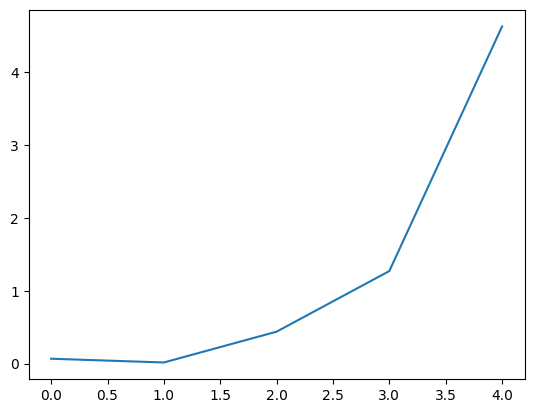

In [78]:
plot(times)

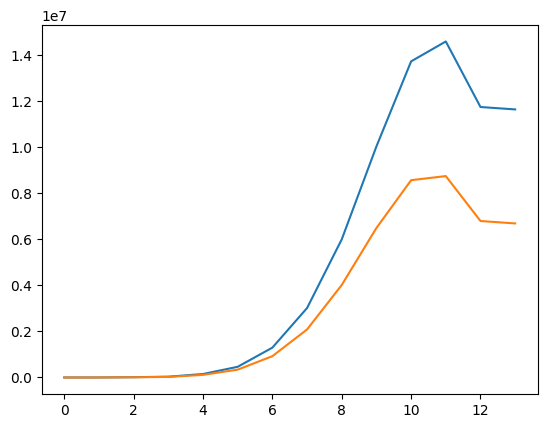

In [114]:
plot(swells)
plot(dag_sizes)

In [77]:
%%time
#reachable = find_reachable_sbfs(teleport_trans, start_bdd)
reachable, swell = find_reachable_special2(start_bdd & valid_design & edit_distance)
#reachable = find_completable_bidirectional(start_bdd, end_bdd, 17)

0 4622
1 4750
2 6189
3 8039
4 8952
5 9821
6 9443
7 9395
8 9567
9 9627
10 9671
11 9790
12 10098
13 10359
14 10525
15 10475
16 10328
17 10220
18 9837
19 9248
20 9184
21 9184
CPU times: user 49.5 ms, sys: 0 ns, total: 49.5 ms
Wall time: 49.1 ms


In [124]:
n = 5
hints = [context.add_expr(f"node_id_prev < ({(i+1) * len(node_ids) // n })") for i in range(n-1)]

In [125]:
# Edit distance hints - ???
#hints = [context.add_expr(all_edits + f" <= {i}") for i in range(max_distance)]

In [139]:
# Item count hints - Probably not very good since we already break apart major item collection
#TODO: this bitwidth thing is a hack
omega.logic.bitvector.ALU_BITWIDTH=42
item_plus = " + ".join(item_prevs)
hints = [context.add_expr(f"{item_plus} < {i}") for i in [3,5,8,10]]

In [140]:
#TODO: region-based search
#TODO: Dag-size restriction

In [141]:
%%time
reachable2 = find_reachable_special_hints(start_bdd & valid_design & edit_distance, hints)

0 0 253199
0 1 253632
0 2 253632
1 0 341666
1 1 342718
1 2 342718
2 0 387589
2 1 511989
2 2 628727
2 3 628727
3 0 837875
3 1 1095781
3 2 1095781
4 0 1118626
4 1 1444157
4 2 1976103
4 3 2832551
4 4 3949709
4 5 5071963
4 6 5821103
4 7 5963718
4 8 5596948
4 9 5014795
4 10 4514951
4 11 4172760
4 12 4026118
4 13 4016113
4 14 4016113
CPU times: user 1min 55s, sys: 581 ms, total: 1min 56s
Wall time: 1min 55s


In [83]:
end_reachable = context.add_expr("node_id_prev = 1")

In [84]:
designs = context.exist(nexts + prevs, reachable)

In [85]:
designs.dag_size

38243

In [86]:
designs.count()

17621.0

In [87]:
good_designs = context.exist(nexts + prevs, reachable & end_reachable)

In [88]:
good_designs.count()

2365.0

In [92]:
good_designs.dag_size / designs.dag_size

0.3186465496953691

In [89]:
good_designs.count() / designs.count()

0.13421485727257249

In [71]:
context.support(good_designs)

{'major_drop_Big_Pink_CB',
 'major_drop_Bomb_Torizo_Bombs',
 'major_drop_Grapple_G',
 'major_drop_Gravity_GS',
 'major_drop_Hi_Jump_HJ',
 'major_drop_Ice_Beam_IB',
 'major_drop_Morph_Ball_Room_MB',
 'major_drop_Plasma_PLB',
 'major_drop_Screw_Attack_SA',
 'major_drop_Space_Jump_SJ',
 'major_drop_Spazer_Spazer',
 'major_drop_Speed_Booster_SB',
 'major_drop_Spring_Ball_SPB',
 'major_drop_Varia_Suit_V',
 'major_drop_Wave_Beam_WB',
 'major_drop_XRay_XR'}

In [95]:
#TODO: "separable trans"
#TODO: git push
#TODO: n_restricted = 1
#TODO: does restricting/unrestricting space jump make a big difference in compute time?
#TODO: colab pro
#TODO: try a transpose representation where each item says what location it is at.
#TODO: Look at nexts in reachable support
#TODO: one-hot location